In [85]:
from scipy.io import arff
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [86]:
# Read in all 5 years record then combine to one dataset
df = pd.DataFrame()

for i in range(1,6):
    path = '../Data/' + str(i) + 'year.arff'
    data = arff.loadarff(path)
    data = pd.DataFrame(data[0])
    df = pd.concat([df, data], ignore_index=True, sort=False)

df.shape

(43405, 65)

In [87]:
df.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,b'0'
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,b'0'
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,b'0'
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,b'0'
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,b'0'


In [88]:
# There are 2 classes: 0 and 1 - dtype is int!
print(df.groupby(['class'])['class'].count())

class
b'0'    41314
b'1'     2091
Name: class, dtype: int64


In [89]:
# Map class to 0 and 1
class_dict = {b'0': '0', b'1': '1'}

df['class'] = df['class'].map(class_dict)
print(df.groupby(['class'])['class'].count())

class
0    41314
1     2091
Name: class, dtype: int64


## EDA

### Missing Values

In [90]:
# Count missing values
df_na = pd.DataFrame(df.isna().sum())
df_na.rename(columns={df_na.columns[0]: 'count'}, inplace = True)

df_na = df_na[df_na['count'] != 0]
df_na['percent_missing'] = df_na['count']/df.shape[0]
df_na = df_na.sort_values('count', ascending=False)

df_na

,count,percent_missing
Attr37,18984,0.437369
Attr21,5854,0.134869
Attr27,2764,0.063679
Attr60,2152,0.049580
Attr45,2147,0.049464
...,...,...
Attr35,8,0.000184
Attr1,8,0.000184
Attr57,7,0.000161
Attr59,7,0.000161


In [91]:
df_na.shape

(64, 2)

Text(0.5, 1.0, 'Correlation Heatmap')

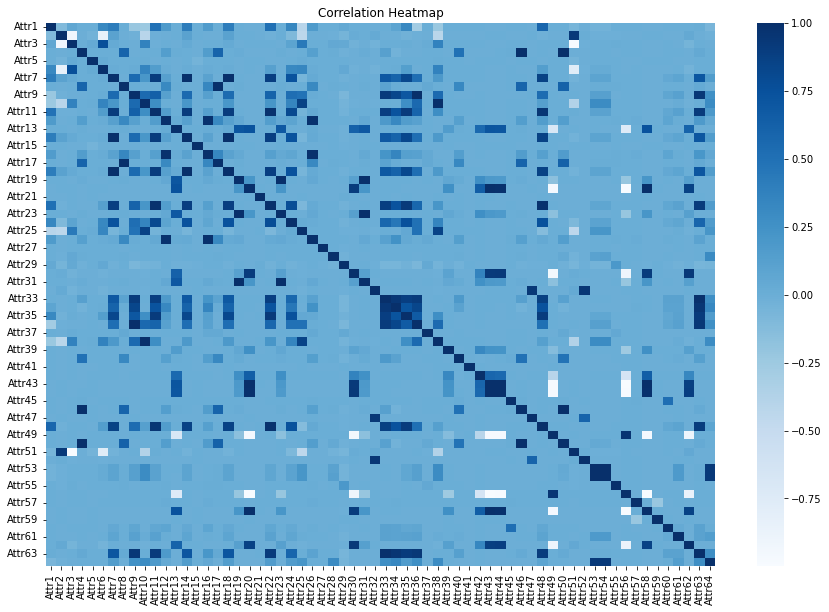

In [92]:
fig = plt.figure(figsize=(15,10))
sns.heatmap(df.corr(method='pearson'), cmap="Blues")
plt.title("Correlation Heatmap")

Random forest in Python are going to require that your complete that your data set is complete.

However, extra boost and gbm will have the ability to use different types of techniques to handle missing values.

- Use StratifiedShuffleSplit to keep the unbalance weight in both train and test dataset.
- Split 20% for test dataset.

In [93]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, test_valid_index in split.split(df, df['class']):
    train = df.iloc[train_index]
    test = df.iloc[test_valid_index]

print("Size of modeling set (to be CV split): ", train.shape)
print(train.groupby(['class'])['class'].count())
print(train['class'].value_counts(normalize=True))
print("Size of hold back validation set: ", test.shape)
print(test.groupby(['class'])['class'].count())
print(test['class'].value_counts(normalize=True))

Size of modeling set (to be CV split):  (39064, 65)
class
0    37182
1     1882
Name: class, dtype: int64
0    0.951823
1    0.048177
Name: class, dtype: float64
Size of hold back validation set:  (4341, 65)
class
0    4132
1     209
Name: class, dtype: int64
0    0.951854
1    0.048146
Name: class, dtype: float64


In [94]:
X_train = train.drop(['class'],axis=1) #droping target
y_train = train['class']
y_train = y_train.astype(int)

X_test = test.drop(['class'],axis=1) #droping target
y_test = test['class']
y_test = y_test.astype(int)

In [98]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

scorer = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'), 
    'f1': make_scorer(f1_score, average='macro')
}

In [141]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

scalar_obj = ColumnTransformer(transformers=[('StandardScaler', StandardScaler(), X_train.columns)], remainder='passthrough') # Default is to drop untransformed columns

model = XGBClassifier(
    nthread = 4,
    seed = 42
)

pipeline = Pipeline([
    ('standard_scaler', scalar_obj), 
    ('model', model)
])

param_grid = {
    'model__eta': [.5], #[0.1, 0.5, 0.8, 1],
    'model__gamma': [1.5], #[1, 1.5, 2, 2.5],
    'model__max_depth': [30], #[10, 20, 30],
    # 'model__n_estimators': [100, 200, 500, 1000],
    # 'model__min_child_weight': [5, 10, 15],
    # 'model__max_leaves': [30,50,70]
    'model__scale_pos_weight': [20, 30]
}

scores = ["recall"]

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    clf = RandomizedSearchCV(pipeline, param_grid, n_jobs=-1, scoring=score)
    clf.fit(X_train, y_train)
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

# Tuning hyper-parameters for recall


/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters set found on development set:
{'model__scale_pos_weight': 20, 'model__max_depth': 30, 'model__gamma': 1.5, 'model__eta': 0.5}

Grid scores on development set:
0.597 (+/-0.043) for {'model__scale_pos_weight': 20, 'model__max_depth': 30, 'model__gamma': 1.5, 'model__eta': 0.5}
0.596 (+/-0.029) for {'model__scale_pos_weight': 30, 'model__max_depth': 30, 'model__gamma': 1.5, 'model__eta': 0.5}



In [142]:
from sklearn.model_selection import cross_validate

best_param = {'model__scale_pos_weight': 20, 'model__gamma': 1.5, 'model__eta': 0.5}

scalar_obj = ColumnTransformer(transformers=[('StandardScaler', StandardScaler(), X_train.columns)], remainder='passthrough') # Default is to drop untransformed columns

xgb_model = XGBClassifier(
    nthread = 4,
    seed = 42,
    scale_pos_weight = 20,
    gamma = 1.5, 
    eta = 0.5,
    max_depth = 30
)

pipeline = Pipeline([
    ('standard_scaler', scalar_obj), 
    ('model', xgb_model)
])

xgb_model_scores = cross_validate(pipeline, X_train, y_train, cv=5, scoring=scorer, error_score="raise")

print("Precision(all models) = ",xgb_model_scores['test_precision'])
print("Recall(all models) = ",xgb_model_scores['test_recall'])
print("F1(all models) = ",xgb_model_scores['test_f1'])
print("\n")
print("Mean Precision = ",xgb_model_scores['test_precision'].mean())
print("Mean Recall = ",xgb_model_scores['test_recall'].mean())
print("Mean F1 = ",xgb_model_scores['test_f1'].mean())

Precision(all models) =  [0.88695545 0.88982803 0.87827054 0.87324365 0.88267846]
Recall(all models) =  [0.79789505 0.78493333 0.79145258 0.7846868  0.81338128]
F1(all models) =  [0.83595029 0.82828417 0.82855825 0.82228579 0.844162  ]


Mean Precision =  0.8821952259133786
Mean Recall =  0.79446980790078
Mean F1 =  0.8318481001445674


In [143]:
xgb_model.fit(X_train, y_train)


X_train_ = scalar_obj.fit_transform(X_train)
X_test_ = scalar_obj.transform(X_test)

print("Detailed classification report:")
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, xgb_model.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4132
           1       0.76      0.61      0.68       209

    accuracy                           0.97      4341
   macro avg       0.87      0.80      0.83      4341
weighted avg       0.97      0.97      0.97      4341




<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

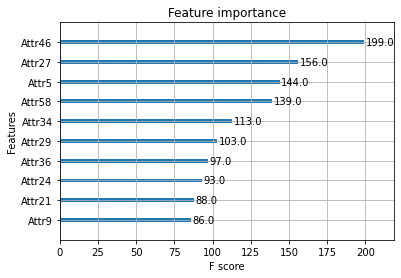

In [139]:
from xgboost import plot_importance

plot_importance(xgb_model, max_num_features=10)

In [102]:
import xgboost as xgb

D_train = xgb.DMatrix(X_train, label = y_train)
D_test = xgb.DMatrix(X_test, label = y_test)

In [126]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report

param = {
    'objective': 'multi:softprob',
    'num_class': 2,
    'nthread': 4,
    'eta': .8, 
    'gamma': 1.5,
}
# objective = 'multi:softmax',
#     num_class = 2,
#     nthread = 4,
        # 'n_estimators':[500,1000],
        # 'eta':[0.001, 0.01,0.1],
        # 'max_depth':[5,15,20],
        # 'max_leaves': [30,50,70],
        # 'min_child_weight': [5, 10, 15],
        # 'gamma': [1, 1.5, 2, 2.5],
        # 'subsample': [0.6, 0.8, 1.0],
        # 'scale_pos_weight': [1,10,20,30]

steps = 20

model = xgb.train(param, D_train)

preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

print(classification_report(y_test, best_preds))

Precision = 0.8836708789067055
Recall = 0.7667047249382808
Accuracy = 0.9709744298548721
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4132
           1       0.79      0.54      0.64       209

    accuracy                           0.97      4341
   macro avg       0.88      0.77      0.81      4341
weighted avg       0.97      0.97      0.97      4341



**scale_pos_weight [default=1]** - Control the balance of positive and negative weights, useful for unbalanced classes. A typical value to consider: sum(negative instances) / sum(positive instances). 

In [128]:
from xgboost import plot_importance

plot_importance(model, max_num_features=10)

NotFittedError: need to call fit or load_model beforehand

**scale_pos_weight** [default=1] - Control the balance of positive and negative weights, useful for unbalanced classes. A typical value to consider: sum(negative instances) / sum(positive instances). 

In [166]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
import time

cv_object = StratifiedKFold(n_splits=5, shuffle=True, random_state=27)

xgb_clf = XGBClassifier(use_label_encoder=False)

num_searches = 10

params = {
        'n_estimators':[500,1000],
        'eta':[0.001, 0.01,0.1],
        'max_depth':[5,15,20],
        'max_leaves': [30,50,70],
        'min_child_weight': [5, 10, 15],
        'gamma': [1, 1.5, 2, 2.5],
        'subsample': [0.6, 0.8, 1.0],
        'scale_pos_weight': [1,10,20,30]
        }

fit_params = {
'early_stopping_rounds': 5,
'eval_metric': 'logloss',
'eval_set': [[X_train, Y_train]]
}


rs_clf = RandomizedSearchCV(xgb_clf, param_distributions=params, n_iter=num_searches, scoring='accuracy', n_jobs=6, cv=cv_object, verbose=3, random_state=42)
print("Randomized search..")
search_time_start = time.time()
rs_clf.fit(X_train, Y_train, **fit_params)
print("Randomized search time:", time.time() - search_time_start)

Randomized search..
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` 

[0]	validation_0-logloss:0.65558
[0]	validation_0-logloss:0.65455
[0]	validation_0-logloss:0.65733
[0]	validation_0-logloss:0.65588
[0]	validation_0-logloss:0.65350
[1]	validation_0-logloss:0.62529
[1]	validation_0-logloss:0.62289
[1]	validation_0-logloss:0.62440
[1]	validation_0-logloss:0.62516
[1]	validation_0-logloss:0.62006
[0]	validation_0-logloss:0.61719
[2]	validation_0-logloss:0.59654
[2]	validation_0-logloss:0.59734
[2]	validation_0-logloss:0.59863
[2]	validation_0-logloss:0.59869
[2]	validation_0-logloss:0.59034
[3]	validation_0-logloss:0.57688
[3]	validation_0-logloss:0.57236
[3]	validation_0-logloss:0.57346
[3]	validation_0-logloss:0.57479
[3]	validation_0-logloss:0.56749
[1]	validation_0-logloss:0.55207
[4]	validation_0-logloss:0.55457
[4]	validation_0-logloss:0.55232
[4]	validation_0-logloss:0.55263
[4]	validation_0-logloss:0.55640
[4]	validation_0-logloss:0.54775
[5]	validation_0-logloss:0.53479
[5]	validation_0-logloss:0.53700
[5]	validation_0-logloss:0.54006
[5]	valida

/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[581]	validation_0-logloss:0.03470
[581]	validation_0-logloss:0.03469
[579]	validation_0-logloss:0.03374
[585]	validation_0-logloss:0.03266
[248]	validation_0-logloss:0.02272
[582]	validation_0-logloss:0.03469
[582]	validation_0-logloss:0.03466
[586]	validation_0-logloss:0.03259
[580]	validation_0-logloss:0.03374
[583]	validation_0-logloss:0.03454
[583]	validation_0-logloss:0.03463
[0]	validation_0-logloss:0.61656
[581]	validation_0-logloss:0.03374
[587]	validation_0-logloss:0.03256
[249]	validation_0-logloss:0.02271
[584]	validation_0-logloss:0.03453
[584]	validation_0-logloss:0.03460
[582]	validation_0-logloss:0.03370
[588]	validation_0-logloss:0.03255
[250]	validation_0-logloss:0.02269
[585]	validation_0-logloss:0.03450
[585]	validation_0-logloss:0.03453
[589]	validation_0-logloss:0.03252
[583]	validation_0-logloss:0.03356
[1]	validation_0-logloss:0.55265
[586]	validation_0-logloss:0.03437
[586]	validation_0-logloss:0.03450
[584]	validation_0-logloss:0.03352
[590]	validation_0-loglo

/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[698]	validation_0-logloss:0.03029
[696]	validation_0-logloss:0.02893
[703]	validation_0-logloss:0.02878
[698]	validation_0-logloss:0.02988
[699]	validation_0-logloss:0.03031
[697]	validation_0-logloss:0.02893
[704]	validation_0-logloss:0.02875
[699]	validation_0-logloss:0.02984
[700]	validation_0-logloss:0.03033
[705]	validation_0-logloss:0.02870
[698]	validation_0-logloss:0.02894
[46]	validation_0-logloss:0.05440
[700]	validation_0-logloss:0.02983
[0]	validation_0-logloss:0.61682
[701]	validation_0-logloss:0.03034
[706]	validation_0-logloss:0.02875
[699]	validation_0-logloss:0.02890
[CV 4/5] END eta=0.1, gamma=2.5, max_depth=5, max_leaves=50, min_child_weight=15, n_estimators=1000, scale_pos_weight=30, subsample=0.8;, score=0.975 total time= 9.1min


/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[701]	validation_0-logloss:0.02980
[707]	validation_0-logloss:0.02874
[700]	validation_0-logloss:0.02888
[702]	validation_0-logloss:0.02969
[47]	validation_0-logloss:0.05331
[701]	validation_0-logloss:0.02882
[708]	validation_0-logloss:0.02875
[1]	validation_0-logloss:0.55331
[703]	validation_0-logloss:0.02966
[702]	validation_0-logloss:0.02872
[709]	validation_0-logloss:0.02872
[0]	validation_0-logloss:0.61692
[704]	validation_0-logloss:0.02965
[703]	validation_0-logloss:0.02866
[710]	validation_0-logloss:0.02871
[CV 5/5] END eta=0.1, gamma=2.5, max_depth=5, max_leaves=50, min_child_weight=15, n_estimators=1000, scale_pos_weight=30, subsample=0.8;, score=0.976 total time= 9.1min


/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[48]	validation_0-logloss:0.05207
[705]	validation_0-logloss:0.02964
[704]	validation_0-logloss:0.02865
[2]	validation_0-logloss:0.49892
[706]	validation_0-logloss:0.02963
[1]	validation_0-logloss:0.55265
[705]	validation_0-logloss:0.02867
[707]	validation_0-logloss:0.02952
[706]	validation_0-logloss:0.02867
[0]	validation_0-logloss:0.61581
[49]	validation_0-logloss:0.05120
[708]	validation_0-logloss:0.02953
[3]	validation_0-logloss:0.45162
[707]	validation_0-logloss:0.02866
[2]	validation_0-logloss:0.49861
[709]	validation_0-logloss:0.02950
[708]	validation_0-logloss:0.02866
[710]	validation_0-logloss:0.02950
[709]	validation_0-logloss:0.02863
[1]	validation_0-logloss:0.55173
[50]	validation_0-logloss:0.05023
[4]	validation_0-logloss:0.41041
[711]	validation_0-logloss:0.02944
[710]	validation_0-logloss:0.02862
[3]	validation_0-logloss:0.45123
[712]	validation_0-logloss:0.02942
[711]	validation_0-logloss:0.02864
[2]	validation_0-logloss:0.49731
[713]	validation_0-logloss:0.02936
[712]	

/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[30]	validation_0-logloss:0.08218
[778]	validation_0-logloss:0.02727
[30]	validation_0-logloss:0.08254
[74]	validation_0-logloss:0.03674
[0]	validation_0-logloss:0.69265
[779]	validation_0-logloss:0.02727
[29]	validation_0-logloss:0.08700
[780]	validation_0-logloss:0.02725
[31]	validation_0-logloss:0.07905
[1]	validation_0-logloss:0.69216
[31]	validation_0-logloss:0.07995
[75]	validation_0-logloss:0.03635
[781]	validation_0-logloss:0.02716
[2]	validation_0-logloss:0.69167
[30]	validation_0-logloss:0.08370
[782]	validation_0-logloss:0.02714
[32]	validation_0-logloss:0.07619
[3]	validation_0-logloss:0.69118
[783]	validation_0-logloss:0.02710
[32]	validation_0-logloss:0.07760
[76]	validation_0-logloss:0.03598
[31]	validation_0-logloss:0.08059
[4]	validation_0-logloss:0.69070
[784]	validation_0-logloss:0.02707
[785]	validation_0-logloss:0.02699
[33]	validation_0-logloss:0.07346
[5]	validation_0-logloss:0.69020
[33]	validation_0-logloss:0.07498
[786]	validation_0-logloss:0.02699
[32]	valida

/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[53]	validation_0-logloss:0.04664
[55]	validation_0-logloss:0.04266
[52]	validation_0-logloss:0.66830
[0]	validation_0-logloss:0.69263
[55]	validation_0-logloss:0.04475
[53]	validation_0-logloss:0.66786
[1]	validation_0-logloss:0.69212
[54]	validation_0-logloss:0.04602
[56]	validation_0-logloss:0.04200
[97]	validation_0-logloss:0.03097
[54]	validation_0-logloss:0.66742
[2]	validation_0-logloss:0.69161
[55]	validation_0-logloss:0.66698
[98]	validation_0-logloss:0.03081
[3]	validation_0-logloss:0.69110
[56]	validation_0-logloss:0.04436
[57]	validation_0-logloss:0.04135
[55]	validation_0-logloss:0.04525
[56]	validation_0-logloss:0.66654
[4]	validation_0-logloss:0.69059
[57]	validation_0-logloss:0.66610
[99]	validation_0-logloss:0.03056
[5]	validation_0-logloss:0.69008
[56]	validation_0-logloss:0.04448
[58]	validation_0-logloss:0.66566
[57]	validation_0-logloss:0.04384
[58]	validation_0-logloss:0.04067
[6]	validation_0-logloss:0.68957
[59]	validation_0-logloss:0.66521
[100]	validation_0-lo

/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[201]	validation_0-logloss:0.02149
[207]	validation_0-logloss:0.02350
[360]	validation_0-logloss:0.55874
[308]	validation_0-logloss:0.57174
[202]	validation_0-logloss:0.02403
[0]	validation_0-logloss:0.69267
[361]	validation_0-logloss:0.55846
[309]	validation_0-logloss:0.57145
[202]	validation_0-logloss:0.02147
[1]	validation_0-logloss:0.69219
[208]	validation_0-logloss:0.02346
[362]	validation_0-logloss:0.55817
[310]	validation_0-logloss:0.57115
[203]	validation_0-logloss:0.02406
[2]	validation_0-logloss:0.69171
[363]	validation_0-logloss:0.55789
[311]	validation_0-logloss:0.57086
[3]	validation_0-logloss:0.69123
[209]	validation_0-logloss:0.02347
[203]	validation_0-logloss:0.02145
[364]	validation_0-logloss:0.55761
[312]	validation_0-logloss:0.57056
[204]	validation_0-logloss:0.02402
[4]	validation_0-logloss:0.69075
[365]	validation_0-logloss:0.55733
[210]	validation_0-logloss:0.02345
[313]	validation_0-logloss:0.57027
[5]	validation_0-logloss:0.69028
[204]	validation_0-logloss:0.021

/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[428]	validation_0-logloss:0.54048
[67]	validation_0-logloss:0.66246
[240]	validation_0-logloss:0.02084
[376]	validation_0-logloss:0.55257
[429]	validation_0-logloss:0.54022
[68]	validation_0-logloss:0.66204
[0]	validation_0-logloss:0.69264
[241]	validation_0-logloss:0.02343
[241]	validation_0-logloss:0.02083
[377]	validation_0-logloss:0.55230
[430]	validation_0-logloss:0.53996
[69]	validation_0-logloss:0.66162
[1]	validation_0-logloss:0.69213
[378]	validation_0-logloss:0.55203
[242]	validation_0-logloss:0.02343
[431]	validation_0-logloss:0.53971
[70]	validation_0-logloss:0.66119
[2]	validation_0-logloss:0.69163
[379]	validation_0-logloss:0.55175
[432]	validation_0-logloss:0.53945
[242]	validation_0-logloss:0.02083
[71]	validation_0-logloss:0.66077
[3]	validation_0-logloss:0.69112
[380]	validation_0-logloss:0.55149
[243]	validation_0-logloss:0.02342
[433]	validation_0-logloss:0.53919
[72]	validation_0-logloss:0.66034
[4]	validation_0-logloss:0.69062
[381]	validation_0-logloss:0.55122
[

/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[405]	validation_0-logloss:0.54490
[458]	validation_0-logloss:0.53297
[97]	validation_0-logloss:0.64998
[29]	validation_0-logloss:0.67835
[406]	validation_0-logloss:0.54463
[459]	validation_0-logloss:0.53273
[98]	validation_0-logloss:0.64958
[0]	validation_0-logloss:0.69265
[259]	validation_0-logloss:0.02330
[30]	validation_0-logloss:0.67787
[407]	validation_0-logloss:0.54437
[460]	validation_0-logloss:0.53248
[99]	validation_0-logloss:0.64917
[1]	validation_0-logloss:0.69216
[31]	validation_0-logloss:0.67740
[408]	validation_0-logloss:0.54411
[461]	validation_0-logloss:0.53224
[100]	validation_0-logloss:0.64876
[260]	validation_0-logloss:0.02328
[2]	validation_0-logloss:0.69167
[32]	validation_0-logloss:0.67692
[409]	validation_0-logloss:0.54386
[462]	validation_0-logloss:0.53199
[101]	validation_0-logloss:0.64836
[3]	validation_0-logloss:0.69118
[33]	validation_0-logloss:0.67644
[410]	validation_0-logloss:0.54359
[261]	validation_0-logloss:0.02324
[102]	validation_0-logloss:0.64796
[

/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[81]	validation_0-logloss:0.65470
[511]	validation_0-logloss:0.52021
[459]	validation_0-logloss:0.53113
[53]	validation_0-logloss:0.66782
[151]	validation_0-logloss:0.62895
[82]	validation_0-logloss:0.65427
[0]	validation_0-logloss:0.60962
[512]	validation_0-logloss:0.51997
[460]	validation_0-logloss:0.53089
[54]	validation_0-logloss:0.66737
[152]	validation_0-logloss:0.62857
[83]	validation_0-logloss:0.65384
[1]	validation_0-logloss:0.54135
[513]	validation_0-logloss:0.51973
[461]	validation_0-logloss:0.53064
[55]	validation_0-logloss:0.66692
[153]	validation_0-logloss:0.62820
[84]	validation_0-logloss:0.65341
[2]	validation_0-logloss:0.48399
[514]	validation_0-logloss:0.51951
[462]	validation_0-logloss:0.53039
[56]	validation_0-logloss:0.66648
[154]	validation_0-logloss:0.62782
[85]	validation_0-logloss:0.65298
[3]	validation_0-logloss:0.43597
[515]	validation_0-logloss:0.51927
[463]	validation_0-logloss:0.53015
[57]	validation_0-logloss:0.66604
[4]	validation_0-logloss:0.39489
[155]

/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[552]	validation_0-logloss:0.51129
[930]	validation_0-logloss:0.44004
[982]	validation_0-logloss:0.43524
[530]	validation_0-logloss:0.51661
[623]	validation_0-logloss:0.50163
[0]	validation_0-logloss:0.60965
[553]	validation_0-logloss:0.51106
[931]	validation_0-logloss:0.43990
[983]	validation_0-logloss:0.43510
[531]	validation_0-logloss:0.51638
[624]	validation_0-logloss:0.50142
[1]	validation_0-logloss:0.54105
[554]	validation_0-logloss:0.51085
[932]	validation_0-logloss:0.43975
[984]	validation_0-logloss:0.43496
[532]	validation_0-logloss:0.51617
[625]	validation_0-logloss:0.50122
[2]	validation_0-logloss:0.48378
[555]	validation_0-logloss:0.51063
[933]	validation_0-logloss:0.43960
[985]	validation_0-logloss:0.43481
[533]	validation_0-logloss:0.51594
[626]	validation_0-logloss:0.50104
[3]	validation_0-logloss:0.43580
[556]	validation_0-logloss:0.51042
[934]	validation_0-logloss:0.43945
[986]	validation_0-logloss:0.43468
[534]	validation_0-logloss:0.51571
[4]	validation_0-logloss:0.3

/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[570]	validation_0-logloss:0.50737
[548]	validation_0-logloss:0.51260
[948]	validation_0-logloss:0.43738
[19]	validation_0-logloss:0.15182
[641]	validation_0-logloss:0.49813
[571]	validation_0-logloss:0.50717
[0]	validation_0-logloss:0.60989
[20]	validation_0-logloss:0.14581
[549]	validation_0-logloss:0.51238
[949]	validation_0-logloss:0.43723
[642]	validation_0-logloss:0.49794
[572]	validation_0-logloss:0.50695
[1]	validation_0-logloss:0.54136
[21]	validation_0-logloss:0.14054
[550]	validation_0-logloss:0.51217
[950]	validation_0-logloss:0.43707
[643]	validation_0-logloss:0.49775
[2]	validation_0-logloss:0.48434
[573]	validation_0-logloss:0.50673
[22]	validation_0-logloss:0.13599
[551]	validation_0-logloss:0.51195
[951]	validation_0-logloss:0.43693
[644]	validation_0-logloss:0.49757
[3]	validation_0-logloss:0.43619
[23]	validation_0-logloss:0.13182
[574]	validation_0-logloss:0.50651
[552]	validation_0-logloss:0.51172
[952]	validation_0-logloss:0.43678
[645]	validation_0-logloss:0.4973

/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[56]	validation_0-logloss:0.08482
[622]	validation_0-logloss:0.49644
[76]	validation_0-logloss:0.07649
[693]	validation_0-logloss:0.48851
[601]	validation_0-logloss:0.50133
[57]	validation_0-logloss:0.08456
[623]	validation_0-logloss:0.49624
[0]	validation_0-logloss:0.60981
[77]	validation_0-logloss:0.07623
[694]	validation_0-logloss:0.48833
[602]	validation_0-logloss:0.50113
[58]	validation_0-logloss:0.08415
[624]	validation_0-logloss:0.49603
[1]	validation_0-logloss:0.54130
[78]	validation_0-logloss:0.07598
[695]	validation_0-logloss:0.48815
[59]	validation_0-logloss:0.08326
[603]	validation_0-logloss:0.50092
[625]	validation_0-logloss:0.49582
[2]	validation_0-logloss:0.48402
[79]	validation_0-logloss:0.07551
[696]	validation_0-logloss:0.48797
[60]	validation_0-logloss:0.08279
[604]	validation_0-logloss:0.50071
[3]	validation_0-logloss:0.43604
[626]	validation_0-logloss:0.49563
[80]	validation_0-logloss:0.07502
[697]	validation_0-logloss:0.48780
[61]	validation_0-logloss:0.08257
[605

/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[929]	validation_0-logloss:0.44176
[422]	validation_0-logloss:0.03838
[343]	validation_0-logloss:0.04306
[401]	validation_0-logloss:0.03766
[910]	validation_0-logloss:0.44758
[0]	validation_0-logloss:0.60976
[423]	validation_0-logloss:0.03821
[402]	validation_0-logloss:0.03764
[930]	validation_0-logloss:0.44160
[344]	validation_0-logloss:0.04302
[911]	validation_0-logloss:0.44744
[1]	validation_0-logloss:0.54150
[424]	validation_0-logloss:0.03816
[403]	validation_0-logloss:0.03762
[345]	validation_0-logloss:0.04285
[931]	validation_0-logloss:0.44143
[912]	validation_0-logloss:0.44729
[2]	validation_0-logloss:0.48461
[425]	validation_0-logloss:0.03807
[346]	validation_0-logloss:0.04280
[404]	validation_0-logloss:0.03761
[932]	validation_0-logloss:0.44130
[913]	validation_0-logloss:0.44714
[426]	validation_0-logloss:0.03803
[3]	validation_0-logloss:0.43622
[347]	validation_0-logloss:0.04266
[405]	validation_0-logloss:0.03758
[933]	validation_0-logloss:0.44115
[914]	validation_0-logloss:0

/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[425]	validation_0-logloss:0.03890
[483]	validation_0-logloss:0.03427
[78]	validation_0-logloss:0.07488
[982]	validation_0-logloss:0.43752
[505]	validation_0-logloss:0.03468
[0]	validation_0-logloss:0.64584
[426]	validation_0-logloss:0.03887
[484]	validation_0-logloss:0.03426
[79]	validation_0-logloss:0.07433
[506]	validation_0-logloss:0.03468
[983]	validation_0-logloss:0.43738
[1]	validation_0-logloss:0.60438
[427]	validation_0-logloss:0.03880
[485]	validation_0-logloss:0.03424
[80]	validation_0-logloss:0.07419
[507]	validation_0-logloss:0.03459
[2]	validation_0-logloss:0.56637
[984]	validation_0-logloss:0.43725
[428]	validation_0-logloss:0.03877
[486]	validation_0-logloss:0.03422
[81]	validation_0-logloss:0.07393
[3]	validation_0-logloss:0.53675
[508]	validation_0-logloss:0.03456
[985]	validation_0-logloss:0.43712
[487]	validation_0-logloss:0.03419
[429]	validation_0-logloss:0.03875
[4]	validation_0-logloss:0.51293
[82]	validation_0-logloss:0.07384
[509]	validation_0-logloss:0.03454


/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[501]	validation_0-logloss:0.03375
[443]	validation_0-logloss:0.03792
[20]	validation_0-logloss:0.32010
[96]	validation_0-logloss:0.07005
[502]	validation_0-logloss:0.03369
[998]	validation_0-logloss:0.43539
[0]	validation_0-logloss:0.64554
[444]	validation_0-logloss:0.03791
[21]	validation_0-logloss:0.31490
[97]	validation_0-logloss:0.06993
[503]	validation_0-logloss:0.03361
[1]	validation_0-logloss:0.60511
[999]	validation_0-logloss:0.43526
[22]	validation_0-logloss:0.31118
[445]	validation_0-logloss:0.03784
[CV 5/5] END eta=0.001, gamma=1.5, max_depth=5, max_leaves=70, min_child_weight=15, n_estimators=1000, scale_pos_weight=20, subsample=1.0;, score=0.868 total time=14.5min


/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[98]	validation_0-logloss:0.06979
[504]	validation_0-logloss:0.03358
[2]	validation_0-logloss:0.57018
[23]	validation_0-logloss:0.30657
[446]	validation_0-logloss:0.03783
[3]	validation_0-logloss:0.54140
[99]	validation_0-logloss:0.06970
[505]	validation_0-logloss:0.03355
[0]	validation_0-logloss:0.64840
[24]	validation_0-logloss:0.30051
[447]	validation_0-logloss:0.03779
[4]	validation_0-logloss:0.51479
[1]	validation_0-logloss:0.60987
[506]	validation_0-logloss:0.03350
[25]	validation_0-logloss:0.29513
[100]	validation_0-logloss:0.06939
[448]	validation_0-logloss:0.03778
[5]	validation_0-logloss:0.49031
[2]	validation_0-logloss:0.57453
[26]	validation_0-logloss:0.28849
[507]	validation_0-logloss:0.03345
[101]	validation_0-logloss:0.06915
[449]	validation_0-logloss:0.03775
[6]	validation_0-logloss:0.46863
[3]	validation_0-logloss:0.54518
[27]	validation_0-logloss:0.28711
[508]	validation_0-logloss:0.03339
[102]	validation_0-logloss:0.06897
[7]	validation_0-logloss:0.44990
[450]	valida

/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[93]	validation_0-logloss:0.16255
[72]	validation_0-logloss:0.19103
[69]	validation_0-logloss:0.19371
[158]	validation_0-logloss:0.05754
[508]	validation_0-logloss:0.03551
[94]	validation_0-logloss:0.16279
[73]	validation_0-logloss:0.18997
[70]	validation_0-logloss:0.19166
[0]	validation_0-logloss:0.64458
[159]	validation_0-logloss:0.05739
[509]	validation_0-logloss:0.03549
[95]	validation_0-logloss:0.16237
[74]	validation_0-logloss:0.18960
[71]	validation_0-logloss:0.19104
[1]	validation_0-logloss:0.60246
[160]	validation_0-logloss:0.05734
[96]	validation_0-logloss:0.16198
[75]	validation_0-logloss:0.18955
[510]	validation_0-logloss:0.03544
[72]	validation_0-logloss:0.18949
[2]	validation_0-logloss:0.57012
[97]	validation_0-logloss:0.16059
[76]	validation_0-logloss:0.18905
[161]	validation_0-logloss:0.05722
[73]	validation_0-logloss:0.18853
[511]	validation_0-logloss:0.03542
[3]	validation_0-logloss:0.54150
[98]	validation_0-logloss:0.15923
[77]	validation_0-logloss:0.18676
[74]	valid

/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[196]	validation_0-logloss:0.05429
[139]	validation_0-logloss:0.12319
[118]	validation_0-logloss:0.13940
[44]	validation_0-logloss:0.23841
[115]	validation_0-logloss:0.14302
[197]	validation_0-logloss:0.05405
[0]	validation_0-logloss:0.64492
[140]	validation_0-logloss:0.12302
[119]	validation_0-logloss:0.13874
[45]	validation_0-logloss:0.23559
[116]	validation_0-logloss:0.14214
[198]	validation_0-logloss:0.05392
[1]	validation_0-logloss:0.60540
[141]	validation_0-logloss:0.12293
[120]	validation_0-logloss:0.13846
[46]	validation_0-logloss:0.23185
[117]	validation_0-logloss:0.14101
[2]	validation_0-logloss:0.57131
[199]	validation_0-logloss:0.05386
[142]	validation_0-logloss:0.12240
[121]	validation_0-logloss:0.13825
[47]	validation_0-logloss:0.22971
[118]	validation_0-logloss:0.13966
[3]	validation_0-logloss:0.54181
[143]	validation_0-logloss:0.12225
[122]	validation_0-logloss:0.13742
[200]	validation_0-logloss:0.05367
[48]	validation_0-logloss:0.22793
[119]	validation_0-logloss:0.1388

KeyboardInterrupt: 

In [127]:
from sklearn.metrics import confusion_matrix

def plot_confusion(cf_matrix):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=2)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
    cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n' for v1, v2 in
    zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    # x_axis_labels = ['<30', '>30']
    # y_axis_labels = ['<30', '>30']
    ax = plt.axes()
    # sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues',xticklabels=x_axis_labels, yticklabels=y_axis_labels)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    ax.set_title('   Bankruptcy Prediction Confusion Matrix\n')
    plt.xlabel("Predicted Bankruptcy")
    plt.ylabel("True Bankruptcy") 

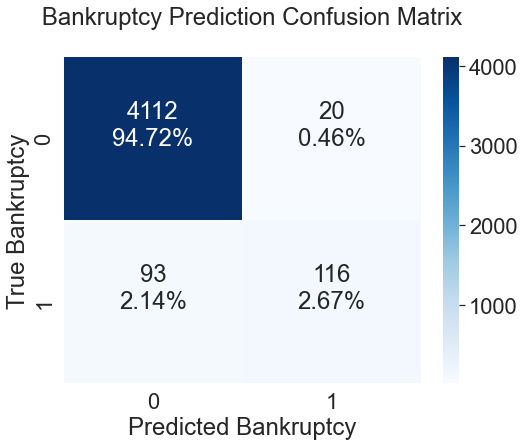

In [143]:
lr_cm = confusion_matrix(Y_test, best_preds)
plot_confusion(lr_cm)